<font size=15>General information</font>

In this kernel i'm working with data from TMDB Box office prediction challenge.

이 커널에서 나는 TMDB 박스 오피스 예측 챌린지의 데이터로 작업 중.

Film industry is booming, the revunews are growing, so we have a lot of data about films.

영화 산업이 호황을 누리고 있고(지금은 아님), 수익이 증가하고 있으므로(이것도 아님), 영화에 대한 많은 데이터가 있음.

Can we build models, which will be able to accurately predict film revenues?

영화 수익을 정확하게 예측할 수 있는 모델을 만들 수 있을까?

Could this models be used to make some changes in movies to increase their revenues even further? 

이 모델들이 미래의 수익을 더 늘리기 위해 영화에 변화를 주는 데 사용할 수 있을까?

I'll try answer this questions in my kernel!

내 커널에서 이 질문에 답해보겠음!

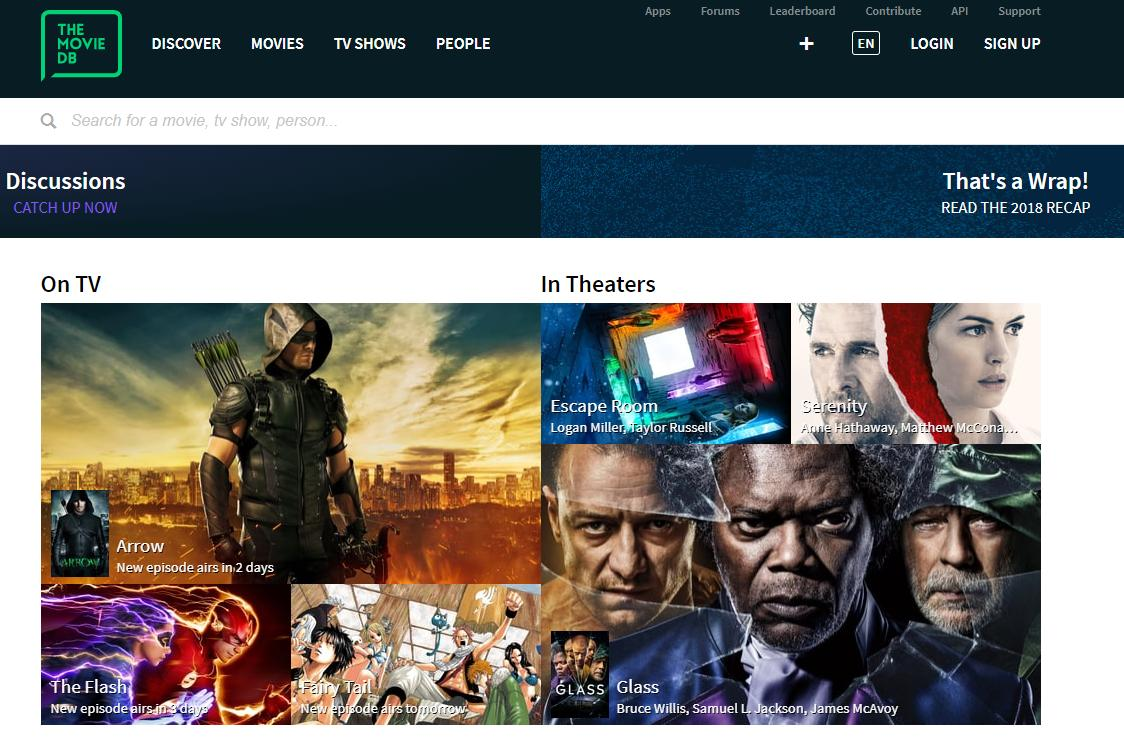

<font size = 10>Content</font>

<b>1  Data loading and overview</b>\
-1.1 belongs to collection\
-1.2 genres\
-1.3 Production companies\
-1.4 Production countires\
-1.5 Spoken languages\
-1.6 Keywords\
-1.7 Cast\
-1.8 Crew

<b>2 Data exploration</b>\
-2.1 Target\
-2.2 Budget\
-2.3 Homepage\
-2.4 Original language\
-2.5 Original title\
-2.6 Overview\
-2.7 Popularity\
-2.8 Release data\
-2.9 Runtime\
-2.10 Status\
-2.11 Tagline\
-2.12 Collections\
-2.13 Genres\
-2.14 Production companies\
-2.15 Production countires\
-2.16 Cast\
-2.17 Keywords\
-2.18 Crew

<b>3  Modelling and feature generation</b>\
-3.1 OOF features based on texts\
-3.2 Additional feature generation\
-3.3 Important features\
-3.4 External features\
-3.5 Blending\
-3.6 Stacking

In [6]:
import numpy as np
import pandas as pd
pd.set_option('max_columns', None)
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')
import datetime
import lightgbm as lgb
from scipy import stats
from scipy.sparse import hstack, csr_matrix
from sklearn.model_selection import train_test_split, KFold
from wordcloud import WordCloud
from collections import Counter
from nltk.corpus import stopwords
from nltk.util import ngrams
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import StandardScaler
stop = set(stopwords.words('english'))
import os
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import xgboost as xgb
import lightgbm as lgb
from sklearn import model_selection
from sklearn.metrics import accuracy_score
import json
import ast
import eli5
import shap
from catboost import CatBoostRegressor
from urllib.request import urlopen
from PIL import Image
from sklearn.preprocessing import LabelEncoder
import time
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn import linear_model

/opt/conda/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning:

The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.

/opt/conda/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning:

The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.

"is not" with a literal. Did you mean "!="?
"is" with a literal. Did you mean "=="?
"is" with a literal. Did you mean "=="?
"is not" with a literal. Did you mean "!="?


# Data loading and overview

In [112]:
train = pd.read_csv('./input/train.csv')
test = pd.read_csv('./input/test.csv')

In [8]:
train.columns

Index(['id', 'belongs_to_collection', 'budget', 'genres', 'homepage',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'runtime', 'spoken_languages',
       'status', 'tagline', 'title', 'Keywords', 'cast', 'crew', 'revenue'],
      dtype='object')

In [11]:
train.describe()

,id,budget,popularity,runtime,revenue
count,3000.000000,3.000000e+03,3000.000000,2998.000000,3.000000e+03
mean,1500.500000,2.253133e+07,8.463274,107.856571,6.672585e+07
std,866.169729,3.702609e+07,12.104000,22.086434,1.375323e+08
min,1.000000,0.000000e+00,0.000001,0.000000,1.000000e+00
25%,750.750000,0.000000e+00,4.018053,94.000000,2.379808e+06
50%,1500.500000,8.000000e+06,7.374861,104.000000,1.680707e+07
75%,2250.250000,2.900000e+07,10.890983,118.000000,6.891920e+07
max,3000.000000,3.800000e+08,294.337037,338.000000,1.519558e+09


In [14]:
train.isna().sum()

Index(['id', 'belongs_to_collection', 'budget', 'genres', 'homepage',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'runtime', 'spoken_languages',
       'status', 'tagline', 'title', 'Keywords', 'cast', 'crew', 'revenue'],
      dtype='object')

In [18]:
pd.DataFrame([train.isna().sum(), test.isna().sum()], index = ['Train', 'Test']).T

,Train,Test
id,0.0,0.0
belongs_to_collection,2396.0,3521.0
budget,0.0,0.0
genres,7.0,16.0
homepage,2054.0,2978.0
imdb_id,0.0,0.0
original_language,0.0,0.0
original_title,0.0,0.0
overview,8.0,14.0
popularity,0.0,0.0


In [21]:
# id는 필요가 없어보임.
# budget도 예산이라
# 장르 필요함
# 홈페이지도 필요없음
# imdb_id는 영화 랭크 사이트에서 해당 영화 아이디인 거 같은데 필요 없음.
# 오리지널 랭기지도 필요업어보임. 
# 오리지널 타이틀도
# 오버뷰도 딱히
# 인기도는 쓸모있어 보이는데 왜 빼는지 잘 모르겠음
# 포스트 패스 필요없음
# 컴페니 결측치가 너무 많음.
# 프로덕트 카운트리는 왜 넣지?
# release_data는 개봉일 말하는거인듯
# 영화시간은 크게 안 중요한듯
# 캐스트 중요함
# 크루 중요함.

train.head()

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue
0,1,"[{'id': 313576, 'name': 'Hot Tub Time Machine ...",14000000,"[{'id': 35, 'name': 'Comedy'}]",NaN,tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,/tQtWuwvMf0hCc2QR2tkolwl7c3c.jpg,"[{'name': 'Paramount Pictures', 'id': 4}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",2/20/15,93.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Laws of Space and Time are About to be Vio...,Hot Tub Time Machine 2,"[{'id': 4379, 'name': 'time travel'}, {'id': 9...","[{'cast_id': 4, 'character': 'Lou', 'credit_id...","[{'credit_id': '59ac067c92514107af02c8c8', 'de...",12314651
1,2,"[{'id': 107674, 'name': 'The Princess Diaries ...",40000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,tt0368933,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,8.248895,/w9Z7A0GHEhIp7etpj0vyKOeU1Wx.jpg,"[{'name': 'Walt Disney Pictures', 'id': 2}]","[{'iso_3166_1': 'US', 'name': 'United States o...",8/6/04,113.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,It can take a lifetime to find true love; she'...,The Princess Diaries 2: Royal Engagement,"[{'id': 2505, 'name': 'coronation'}, {'id': 42...","[{'cast_id': 1, 'character': 'Mia Thermopolis'...","[{'credit_id': '52fe43fe9251416c7502563d', 'de...",95149435
2,3,NaN,3300000,"[{'id': 18, 'name': 'Drama'}]",http://sonyclassics.com/whiplash/,tt2582802,en,Whiplash,"Under the direction of a ruthless instructor, ...",64.299990,/lIv1QinFqz4dlp5U4lQ6HaiskOZ.jpg,"[{'name': 'Bold Films', 'id': 2266}, {'name': ...","[{'iso_3166_1': 'US', 'name': 'United States o...",10/10/14,105.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The road to greatness can take you to the edge.,Whiplash,"[{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'n...","[{'cast_id': 5, 'character': 'Andrew Neimann',...","[{'credit_id': '54d5356ec3a3683ba0000039', 'de...",13092000
3,4,NaN,1200000,"[{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n...",http://kahaanithefilm.com/,tt1821480,hi,Kahaani,Vidya Bagchi (Vidya Balan) arrives in Kolkata ...,3.174936,/aTXRaPrWSinhcmCrcfJK17urp3F.jpg,NaN,"[{'iso_3166_1': 'IN', 'name': 'India'}]",3/9/12,122.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,NaN,Kahaani,"[{'id': 10092, 'name': 'mystery'}, {'id': 1054...","[{'cast_id': 1, 'character': 'Vidya Bagchi', '...","[{'credit_id': '52fe48779251416c9108d6eb', 'de...",16000000
4,5,NaN,0,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",NaN,tt1380152,ko,마린보이,Marine Boy is the story of a former national s...,1.148070,/m22s7zvkVFDU9ir56PiiqIEWFdT.jpg,NaN,"[{'iso_3166_1': 'KR', 'name': 'South Korea'}]",2/5/09,118.0,"[{'iso_639_1': 'ko', 'name': '한국어/조선말'}]",Released,NaN,Marine Boy,NaN,"[{'cast_id': 3, 'character': 'Chun-soo', 'cred...","[{'credit_id': '52fe464b9251416c75073b43', 'de...",3923970


In [39]:
test.belongs_to_collection[0]

"[{'id': 34055, 'name': 'Pokémon Collection', 'poster_path': '/j5te0YNZAMXDBnsqTUDKIBEt8iu.jpg', 'backdrop_path': '/iGoYKA0TFfgSoZpG2u5viTJMGfK.jpg'}]"

In [113]:
dict_columns = ['belongs_to_collection', 'genres', 'production_companies',
                'production_countries', 'spoken_languages', 'Keywords', 'cast', 'crew']

def text_to_dict(df):
    for column in dict_columns:
        # na면 거르고 값이 있으면  바꿔주기
        df[column] = df[column].apply(lambda x: {} if pd.isna(x) else ast.literal_eval(x))
    return df

text_to_dict(train)
text_to_dict(test)

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew
0,3001,"[{'id': 34055, 'name': 'Pokémon Collection', '...",0,"[{'id': 12, 'name': 'Adventure'}, {'id': 16, '...",http://www.pokemon.com/us/movies/movie-pokemon...,tt1226251,ja,ディアルガVSパルキアVSダークライ,Ash and friends (this time accompanied by newc...,3.851534,/tnftmLMemPLduW6MRyZE0ZUD19z.jpg,{},"[{'iso_3166_1': 'JP', 'name': 'Japan'}, {'iso_...",7/14/07,90.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Somewhere Between Time & Space... A Legend Is ...,Pokémon: The Rise of Darkrai,"[{'id': 11451, 'name': 'pok√©mon'}, {'id': 115...","[{'cast_id': 3, 'character': 'Tonio', 'credit_...","[{'credit_id': '52fe44e7c3a368484e03d683', 'de..."
1,3002,{},88000,"[{'id': 27, 'name': 'Horror'}, {'id': 878, 'na...",NaN,tt0051380,en,Attack of the 50 Foot Woman,When an abused wife grows to giant size becaus...,3.559789,/9MgBNBqlH1sG4yG2u4XkwI5CoJa.jpg,"[{'name': 'Woolner Brothers Pictures Inc.', 'i...","[{'iso_3166_1': 'US', 'name': 'United States o...",5/19/58,65.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,A titanic beauty spreads a macabre wave of hor...,Attack of the 50 Foot Woman,"[{'id': 9748, 'name': 'revenge'}, {'id': 9951,...","[{'cast_id': 2, 'character': 'Nancy Fowler Arc...","[{'credit_id': '55807805c3a3685b1300060b', 'de..."
2,3003,{},0,"[{'id': 35, 'name': 'Comedy'}, {'id': 10749, '...",NaN,tt0118556,en,Addicted to Love,Good-natured astronomer Sam is devastated when...,8.085194,/ed6nD7h9sbojSWY2qrnDcSvDFko.jpg,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",5/23/97,100.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,A Comedy About Lost Loves And Last Laughs,Addicted to Love,"[{'id': 931, 'name': 'jealousy'}, {'id': 9673,...","[{'cast_id': 11, 'character': 'Maggie', 'credi...","[{'credit_id': '52fe4330c3a36847f8041367', 'de..."
3,3004,{},6800000,"[{'id': 18, 'name': 'Drama'}, {'id': 10752, 'n...",http://www.sonyclassics.com/incendies/,tt1255953,fr,Incendies,A mother's last wishes send twins Jeanne and S...,8.596012,/sEUG3qjxwHjxkzuO7plrRHhOZUH.jpg,"[{'name': 'TS Productions', 'id': 313}, {'name...","[{'iso_3166_1': 'CA', 'name': 'Canada'}, {'iso...",9/4/10,130.0,"[{'iso_639_1': 'fr', 'name': 'Français'}, {'is...",Released,The search began at the opening of their mothe...,Incendies,"[{'id': 378, 'name': 'prison'}, {'id': 539, 'n...","[{'cast_id': 6, 'character': 'Nawal', 'credit_...","[{'credit_id': '56478092c3a36826140043af', 'de..."
4,3005,{},2000000,"[{'id': 36, 'name': 'History'}, {'id': 99, 'na...",NaN,tt0418753,en,Inside Deep Throat,"In 1972, a seemingly typical shoestring budget...",3.217680,/n4WC3zbelz6SG7rhkWbf8m9pMHB.jpg,{},"[{'iso_3166_1': 'US', 'name': 'United States o...",2/11/05,92.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,It was filmed in 6 days for 25 thousand dollar...,Inside Deep Throat,"[{'id': 279, 'name': 'usa'}, {'id': 1228, 'nam...","[{'cast_id': 1, 'character': 'Narrator (voice)...","[{'credit_id': '52fe44ce9251416c75041967', 'de..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4393,7394,{},42000000,"[{'id': 53, 'name': 'Thriller'}]",NaN,tt0218922,en,Original Sin,A young man is plunged into a life of subterfu...,9.970359,/i8FEQy5IWAqOzXm4uDHy2r3Swym.jpg,"[{'name': 'Intermedia Films', 'id': 763}, {'na...","[{'iso_3166_1': 'FR', 'name': 'France'}, {'iso...",8/3/01,118.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,This is not a love story - it's a story about ...,Original Sin,"[{'id': 515, 'name': 'women'}, {'id': 572, 'na...","[{'cast_id': 17, 'character': 'Julia Russell/B...","[{'credit_id': '52fe4330c3a36847f80412db', 'de..."
4394,7395,"[{'id': 146534, 'name': 'Without a Paddle Coll...",19000000,"[{'id': 28, 'name': '

There are only 3000 samples in train data!
트레인에는 3000개의 샘플만 있네.

Let's hope this is enough to train model.

이것이 모델을 훈련하기에 충분하기를 바람.

We can see that some of columns contain lists with dictionaries.

일부 열에 사전이 포함된 리스트가 있음.

Some lists contain a single dictionary, some have several.

어떤 목록에는 하나의 사전만 있고, 어떤 목록에는 여러 개의 사전이 있음.

Let's extract data from these columns.

이 컬럼들의 데이터를 추출해보자.

## belong_to_collection

In [44]:
for i, e in enumerate(train['belongs_to_collection'][:5]):
    print(i, e)

0 [{'id': 313576, 'name': 'Hot Tub Time Machine Collection', 'poster_path': '/iEhb00TGPucF0b4joM1ieyY026U.jpg', 'backdrop_path': '/noeTVcgpBiD48fDjFVic1Vz7ope.jpg'}]
1 [{'id': 107674, 'name': 'The Princess Diaries Collection', 'poster_path': '/wt5AMbxPTS4Kfjx7Fgm149qPfZl.jpg', 'backdrop_path': '/zSEtYD77pKRJlUPx34BJgUG9v1c.jpg'}]
2 {}
3 {}
4 {}


In [46]:
train['belongs_to_collection'].apply(lambda x: len(x) if x != {} else 0).value_counts()

0    2396
1     604
Name: belongs_to_collection, dtype: int64

2396 values in this columns are empty, 604 contrain information about the collections.

이 열의 2396값은 비어있고, 604는 컬렉션에 대한 정보가 있음.

I suppose that only collection name can be useful.

컬렉션 이름만 유용할 수 있다고 가정함.

Another possibly useful feature is the fact of belonging to a collection.

또 다른 유용할 수 있는 특징은 컬렉션에 속해있다는 사실.

In [114]:
train['collection_name'] = train['belongs_to_collection'].apply(lambda x: x[0]['name'] if x != {} else 0)
train['has_collection'] = train['belongs_to_collection'].apply(lambda x: len(x) if x != {} else 0)

test['collection_name'] = test['belongs_to_collection'].apply(lambda x: x[0]['name'] if x != {} else 0)
test['has_collection'] = test['belongs_to_collection'].apply(lambda x: len(x) if x != {} else 0)

In [115]:
train = train.drop(['belongs_to_collection'], axis = 1)
test = test.drop(['belongs_to_collection'], axis = 1)

## genres

In [53]:
for i, e in enumerate(train['genres'][:5]):
    print(i, e)

0 [{'id': 35, 'name': 'Comedy'}]
1 [{'id': 35, 'name': 'Comedy'}, {'id': 18, 'name': 'Drama'}, {'id': 10751, 'name': 'Family'}, {'id': 10749, 'name': 'Romance'}]
2 [{'id': 18, 'name': 'Drama'}]
3 [{'id': 53, 'name': 'Thriller'}, {'id': 18, 'name': 'Drama'}]
4 [{'id': 28, 'name': 'Action'}, {'id': 53, 'name': 'Thriller'}]


In [58]:
print('Number of genres in films')
train['genres'].apply(lambda x: len(x) if x != {} else 0).value_counts().sort_index()

Number of genres in films


0      7
1    593
2    972
3    900
4    393
5    111
6     21
7      3
Name: genres, dtype: int64

Genres columns contains named and ids of genres to which films belong.

장르 열에는 영화가 속한 장르의 이름이랑 id가 포함됨.

Most of films have 2-3 genres and 5-6 genres are possible.

대부분 영화는 2~3장르를 갖고 있고 5-6도 가능함.

0 and 7 are outliers, i think.

내 생각에 0이랑 7은 아웃라이어임.

Let's extract genres!

장르를 추출하자.

I'll create a columns with all genres in the film and also separate columns for each genre.

영화에 있는 모든 장르의 컬럼을 만들고, 각 장르별로 컬럼을 구분해줄 거임.

But at first let's have a look at the genres themselves.

하지만 먼저 장르 전체를 보자.

In [116]:
list_of_genres =\
list(train['genres'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)

In [64]:
train['genres'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values

array([list(['Comedy']), list(['Comedy', 'Drama', 'Family', 'Romance']),
       list(['Drama']), ...,
       list(['Crime', 'Action', 'Mystery', 'Thriller']),
       list(['Comedy', 'Romance']),
       list(['Thriller', 'Action', 'Mystery'])], dtype=object)

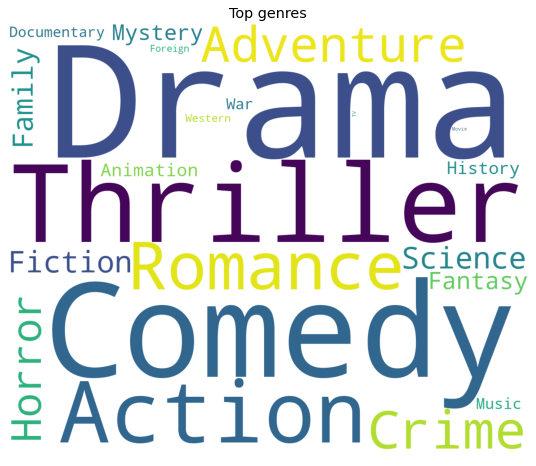

In [74]:
plt.figure(figsize = (12, 8))
text = ' '.join([i for i in list_of_genres for i in i])
wordcloud = WordCloud(max_font_size = None, background_color = 'white', collocations= False,
                     width = 1200, height = 1000).generate(text)
plt.imshow(wordcloud)
plt.title('Top genres')
plt.axis('off')
plt.show()

Drama, Comedy and Thriller are popular genres.
트라마 ,코미디, 스릴러는 인기있는 장르임.

In [78]:
i = 2

In [86]:
Counter([i for i in list_of_genres for i in i]).most_common()

[('Drama', 1531),
 ('Comedy', 1028),
 ('Thriller', 789),
 ('Action', 741),
 ('Romance', 571),
 ('Crime', 469),
 ('Adventure', 439),
 ('Horror', 301),
 ('Science Fiction', 290),
 ('Family', 260),
 ('Fantasy', 232),
 ('Mystery', 225),
 ('Animation', 141),
 ('History', 132),
 ('Music', 100),
 ('War', 100),
 ('Documentary', 87),
 ('Western', 43),
 ('Foreign', 31),
 ('TV Movie', 1)]

I'll create separate columns for top-15 genres.

탑 15개 장르를 위한 구분 컬럼을 만듦.

In [117]:
train['num_genres'] = train['genres'].apply(lambda x: len(x) if x != {} else 0)
train['all_genres'] = train['genres'].apply(lambda x: \
                                            ' '.join(sorted([i['name'] for i in x]))\
                                           if x != {} else '')
top_genres = [m[0] for m in Counter([i for j in list_of_genres for i in j]).most_common(15)]

for g in top_genres:
    train['genre_' + g] = train['all_genres'].apply(lambda x: 1 if x != {} else 0)

In [118]:
test['num_genres'] = test['genres'].apply(lambda x: len(x) if x != {} else 0)
test['all_genres'] = test['genres'].apply(lambda x: \
                                            ' '.join(sorted([i['name'] for i in x]))\
                                           if x != {} else '')
top_genres = [m[0] for m in Counter([i for j in list_of_genres for i in j]).most_common(15)]

for g in top_genres:
    test['genre_' + g] = test['all_genres'].apply(lambda x: 1 if x != {} else 0)

In [119]:
train = train.drop(['genres'], axis = 1)
test = test.drop(['genres'], axis = 1)

## production_companies

In [94]:
for i, e in enumerate(train['production_companies'][:5]):
    print(i, e)

0 [{'name': 'Paramount Pictures', 'id': 4}, {'name': 'United Artists', 'id': 60}, {'name': 'Metro-Goldwyn-Mayer (MGM)', 'id': 8411}]
1 [{'name': 'Walt Disney Pictures', 'id': 2}]
2 [{'name': 'Bold Films', 'id': 2266}, {'name': 'Blumhouse Productions', 'id': 3172}, {'name': 'Right of Way Films', 'id': 32157}]
3 {}
4 {}


In [95]:
print('Number of production companies in films')
train['production_companies'].apply(lambda x: len(x) if x != {} else 0).value_counts()

Number of production companies in films


1     775
2     734
3     582
4     312
5     166
0     156
6     118
7      62
8      42
9      29
11      7
10      7
12      3
16      2
15      2
14      1
13      1
17      1
Name: production_companies, dtype: int64

Most of films have 1-2 production companies, sometimes 3-4.

대부분의 영화는 1-2 제작사로 되어 있고, 가끔 3-4.

But there are films with 10+ compaines!

하지만 10개 이상이 참여한 회사가 있음.

Let's have a look at some of them.

그들 중 일부를 살펴보자.

In [120]:
train[train['production_companies'].apply(lambda x: len(x) if x != {} else 0) > 11]

,id,budget,homepage,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue,collection_name,has_collection,num_genres,all_genres,genre_Drama,genre_Comedy,genre_Thriller,genre_Action,genre_Romance,genre_Crime,genre_Adventure,genre_Horror,genre_Science Fiction,genre_Family,genre_Fantasy,genre_Mystery,genre_Animation,genre_History,genre_Music
31,32,0,http://www.cache-derfilm.at,tt0387898,fr,Caché,A married couple is terrorized by a series of ...,5.695860,/i1Zl8S4DgM3IDLW5dhZzBnIdCOe.jpg,"[{'name': 'Les Films du Losange', 'id': 223}, ...","[{'iso_3166_1': 'AT', 'name': 'Austria'}, {'is...",5/2/05,117.0,"[{'iso_639_1': 'fr', 'name': 'Français'}]",Released,NaN,Caché,"[{'id': 90, 'name': 'paris'}, {'id': 213, 'nam...","[{'cast_id': 2, 'character': 'Georges Laurent'...","[{'credit_id': '52fe4244c3a36847f8011073', 'de...",36000000,0,0,3,Drama Mystery Thriller,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
116,117,0,NaN,tt2113822,zh,一九四二,"In 1942, Henan Province was devastated by the ...",1.678013,/xxz2gi8vijqqJySGO3kQy2i8mv.jpg,"[{'name': 'Emperor Motion Pictures', 'id': 272...","[{'iso_3166_1': 'CN', 'name': 'China'}]",11/1/12,145.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,NaN,Back to 1942,"[{'id': 478, 'name': 'china'}, {'id': 180999, ...","[{'cast_id': 3, 'character': 'Theodore Harold ...","[{'credit_id': '5761375dc3a36808aa001554', 'de...",311,0,0,1,Drama,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
363,364,15400000,NaN,tt2053425,fr,De rouille et d'os,"Put in charge of his young son, Ali leaves Bel...",8.400049,/cHCwW8xPl8yPKQwpNzKVinwvirT.jpg,"[{'name': 'France 2 Cinéma', 'id': 83}, {'name...","[{'iso_3166_1': 'FR', 'name': 'France'}, {'iso...",5/17/12,123.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,NaN,Rust and Bone,"[{'id': 494, 'name': 'father son relationship'...","[{'cast_id': 2, 'character': 'St√©phanie', 'cr...","[{'credit_id': '52fe49dd9251416c750d5e05', 'de...",25762027,0,0,2,Drama Romance,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
392,393,0,NaN,tt5072406,fr,Moka,Diane Kramer is led by one obsession: to find ...,2.404466,/5VKVaTJJsyDeOzY6fLcyTo1RA9g.jpg,"[{'name': 'Canal+', 'id': 5358}, {'name': 'Cin...","[{'iso_3166_1': 'FR', 'name': 'France'}, {'iso...",8/17/16,89.0,"[{'iso_639_1': 'fr', 'name': 'Français'}]",Released,NaN,Moka,{},"[{'cast_id': 1, 'character': 'Diane', 'credit_...","[{'credit_id': '59619ddd9251410bfa0cf8e5', 'de...",126463,0,0,1,Drama,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
449,450,80000000,http://asoundofthunder.warnerbros.com/,tt0318081,en,A Sound of Thunder,When a hunter sent back to the prehistoric era...,4.980191,/gsqOX1ReJ5lcmTuDdkhOXLug8Ug.jpg,"[{'name': 'Epsilon Motion Pictures', 'id': 117...","[{'iso_3166_1': 'CZ', 'name': 'Czech Republic'...",5/15/05,110.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Some Rules Should Never Be Broken.,A Sound of Thunder,"[{'id': 3737, 'name': 'dying and death'}, {'id...","[{'cast_id': 34, 'character': 'Alicia Wallenbe...","[{'credit_id': '52fe431e9251416c7500438b', 'de...",5989640,0,0,4,Action Adventure Science Fiction Thriller,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
554,555,14500000,NaN,tt0293416,ja,Metropolis,Duke Red has overseen the construction of a ma...,9.298092,/1EK7mGCpRKYmSg25FaojvnS9opm.jpg,"[{'name': 'Bandai Visual Company', 'id': 528},...","[{'iso_3166_1': 'JP', 'name': 'Japan'}]",5/26/01,108.0,"[{'iso_639_1': 'ru', 'name': 'Pусский'}, {'iso...",Released,Welcome to Metropolis,Metropolis,"[{'id': 931, 'name': 'jealousy'}, {'id': 1761,...","[{'cast_id': 1, 'character': 'Tima (voice)', '...","[{'credit_id': '52fe4510c3a36847f80ba41d', 'de...",95789342,0,0,2,Animation Science Fiction,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
1079,1080,7000000,NaN,tt2737050,fr,"Deux jours, une nuit",Sandra is a young woman who has only one weeke...,6.868022,/1mYAejpMskvskGr0J0SaBvdjmrH.jpg,"[{'name': 'BIM Distribuzione', 'id': 225}, {'n...","[{'iso_

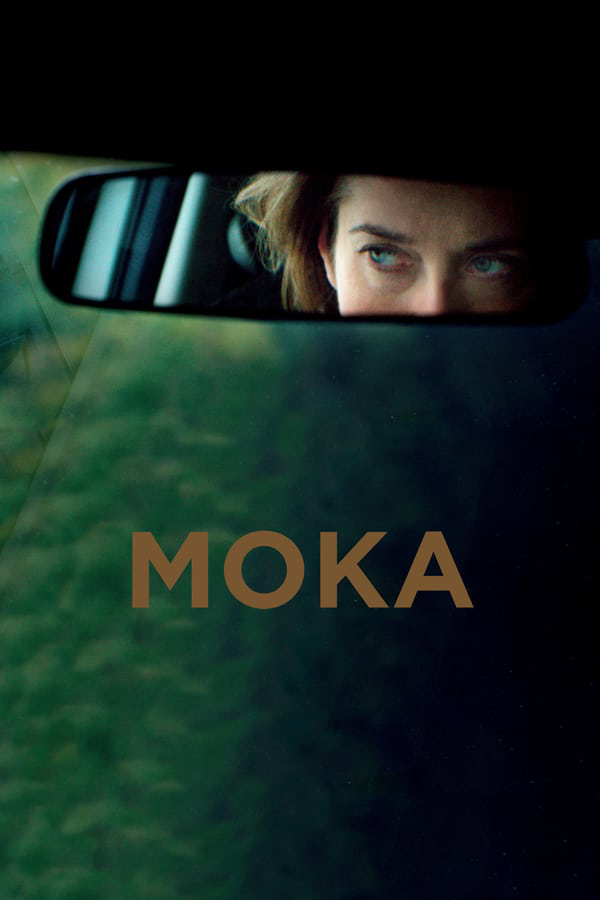

In [121]:
# example of poster of such a film

Image.open(urlopen("https://image.tmdb.org/t/p/w600_and_h900_bestv2/5VKVaTJJsyDeOzY6fLcyTo1RA9g.jpg"))

In [122]:
list_of_companies = list(train['production_companies'].apply(lambda x: \
                    [i['name'] for i in x] if x != {} else []).values)

In [124]:
Counter([i for j in list_of_companies for i in j]).most_common(30)

[('Warner Bros.', 202),
 ('Universal Pictures', 188),
 ('Paramount Pictures', 161),
 ('Twentieth Century Fox Film Corporation', 138),
 ('Columbia Pictures', 91),
 ('Metro-Goldwyn-Mayer (MGM)', 84),
 ('New Line Cinema', 75),
 ('Touchstone Pictures', 63),
 ('Walt Disney Pictures', 62),
 ('Columbia Pictures Corporation', 61),
 ('TriStar Pictures', 53),
 ('Relativity Media', 48),
 ('Canal+', 46),
 ('United Artists', 44),
 ('Miramax Films', 40),
 ('Village Roadshow Pictures', 36),
 ('Regency Enterprises', 31),
 ('BBC Films', 30),
 ('Dune Entertainment', 30),
 ('Working Title Films', 30),
 ('Fox Searchlight Pictures', 29),
 ('StudioCanal', 28),
 ('Lionsgate', 28),
 ('DreamWorks SKG', 27),
 ('Fox 2000 Pictures', 25),
 ('Summit Entertainment', 24),
 ('Hollywood Pictures', 24),
 ('Orion Pictures', 24),
 ('Amblin Entertainment', 23),
 ('Dimension Films', 23)]

For now I'm not sure what to do with this data.

지금은 이 데이터를 어떻게 해야 할지 모르겠다.

I'll simply create binary columns for top-30 films.

나중에 탑30개 필름에 대한 바이너리를 만들 거임.


Maybe later I'll have a better idea.

나중에 더 좋은 생각이 날지 몰라

In [ ]:
train['num_companies'] = train['production_companies']\
.apply(lambda x: len(x) if x !={} else 0)
train['all_production_companies'] = train['production_companies']\
.apply(lambda x: ' '.join(sorted(i['name'] for i in x]))\
       if x != {} else '')
for j in top_companies:
    train['production_company_']